# Tutorial 7: Parallel Optimisation

**Learning Objectives:**
- Understand which optimisers support parallelism
- Configure population-based optimisers for parallel execution
- Benchmark scaling performance
- Identify performance bottlenecks
- Apply best practices for thread-safe optimisation

**Prerequisites:** Tutorials 1-2, basic understanding of parallelism

**Runtime:** ~10 minutes

## Introduction

Modern CPUs have multiple cores, but not all optimisation algorithms can exploit them. Chronopt provides **automatic parallelisation** for population-based algorithms:

### Parallel Optimisers
- **CMA-ES**: Population-based evolutionary strategy
- **Dynamic Nested Sampling**: Population of live points

### Sequential Optimisers  
- **Nelder-Mead**: Sequential simplex updates
- **Adam**: Sequential gradient steps

This tutorial demonstrates how to configure parallelism and measure its impact.

In [1]:
import multiprocessing

# Import plotting utilities
import time

import chronopt as chron
import matplotlib.pyplot as plt
import numpy as np

# Detect available cores
n_cores = multiprocessing.cpu_count()
print(f"Available CPU cores: {n_cores}")

Available CPU cores: 8


## Test Problem: Expensive Rosenbrock

To see the benefits of parallelism, we need an **expensive** objective function. Let's add artificial computation time:

In [2]:
def expensive_rosenbrock(x, delay_ms=10):
    """
    Rosenbrock function with artificial delay to simulate expensive computation.

    In real applications, this might be:
    - Complex ODE simulation
    - Finite element analysis
    - Machine learning model evaluation
    - Database query
    """
    # Simulate expensive computation
    time.sleep(delay_ms / 1000.0)

    # Standard Rosenbrock
    value = (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2
    return np.array([value], dtype=float)


# Test single evaluation
start = time.time()
result = expensive_rosenbrock([0.5, 0.5], delay_ms=50)
elapsed = time.time() - start

print(f"Single evaluation time: {elapsed:.3f}s")
print(f"Objective value: {result[0]:.3f}")

Single evaluation time: 0.055s
Objective value: 6.500


## Sequential Baseline: Nelder-Mead

First, establish a baseline with sequential Nelder-Mead:

In [3]:
# Build problem
problem = (
    chron.ScalarBuilder()
    .with_objective(lambda x: expensive_rosenbrock(x, delay_ms=10))
    .with_parameter("x", 1.0)
    .with_parameter("y", 1.0)
    .build()
)

# Sequential Nelder-Mead
print("Running Nelder-Mead (sequential)...")
start = time.time()

result_nm = chron.NelderMead().with_max_iter(100).run(problem, [0.0, 0.0])

time_nm = time.time() - start

print("\n" + "=" * 60)
print("NELDER-MEAD (Sequential)")
print("=" * 60)
print(f"Solution:      {result_nm.x}")
print(f"Value:         {result_nm.value:.3e}")
print(f"Evaluations:   {result_nm.evaluations}")
print(f"Time:          {time_nm:.2f}s")
print(f"Time per eval: {time_nm / result_nm.evaluations:.3f}s")

Running Nelder-Mead (sequential)...



NELDER-MEAD (Sequential)
Solution:      [1.0007473  1.00148331]
Value:         5.725e-07
Evaluations:   127
Time:          1.44s
Time per eval: 0.011s


## Parallel Optimisation: CMA-ES

CMA-ES evaluates a **population** of candidate solutions each generation. Chronopt automatically parallelises these evaluations across available cores.

### Key Parameters:
- `population_size`: Number of candidates per generation (default: automatic based on dimension)
- More candidates = more parallelism opportunity
- Trade-off: larger populations need more generations to converge

In [4]:
# CMA-ES with automatic population size
print("Running CMA-ES (parallel, default population)...")
start = time.time()

result_cmaes_default = (
    chron.CMAES().with_max_iter(50).with_step_size(0.5).run(problem, [0.0, 0.0])
)

time_cmaes_default = time.time() - start

print("\n" + "=" * 60)
print("CMA-ES (Parallel, Default Population)")
print("=" * 60)
print(f"Solution:      {result_cmaes_default.x}")
print(f"Value:         {result_cmaes_default.value:.3e}")
print(f"Evaluations:   {result_cmaes_default.evaluations}")
print(f"Time:          {time_cmaes_default:.2f}s")
print(f"Time per eval: {time_cmaes_default / result_cmaes_default.evaluations:.3f}s")
print(f"\nSpeedup vs Nelder-Mead: {time_nm / time_cmaes_default:.2f}x")

Running CMA-ES (parallel, default population)...



CMA-ES (Parallel, Default Population)
Solution:      [0.98713938 0.97199636]
Value:         7.646e-04
Evaluations:   301
Time:          3.40s
Time per eval: 0.011s

Speedup vs Nelder-Mead: 0.42x


In [5]:
# CMA-ES with larger population for more parallelism
print("Running CMA-ES (parallel, large population)...")
start = time.time()

result_cmaes_large = (
    chron.CMAES()
    .with_max_iter(30)
    .with_step_size(0.5)
    .with_population_size(20)  # Larger population = more parallel work
    .run(problem, [0.0, 0.0])
)

time_cmaes_large = time.time() - start

print("\n" + "=" * 60)
print("CMA-ES (Parallel, Large Population)")
print("=" * 60)
print(f"Solution:      {result_cmaes_large.x}")
print(f"Value:         {result_cmaes_large.value:.3e}")
print(f"Evaluations:   {result_cmaes_large.evaluations}")
print(f"Time:          {time_cmaes_large:.2f}s")
print(f"Time per eval: {time_cmaes_large / result_cmaes_large.evaluations:.3f}s")
print(f"\nSpeedup vs Nelder-Mead: {time_nm / time_cmaes_large:.2f}x")

Running CMA-ES (parallel, large population)...



CMA-ES (Parallel, Large Population)
Solution:      [0.98069027 0.96068513]
Value:         4.870e-04
Evaluations:   601
Time:          6.81s
Time per eval: 0.011s

Speedup vs Nelder-Mead: 0.21x


## Scaling Analysis

Let's systematically test how performance scales with:
1. **Population size** (parallelism opportunity)
2. **Evaluation cost** (compute vs overhead trade-off)

In [6]:
# Test different population sizes
population_sizes = [4, 8, 12, 16, 20]
results_pop = []

print("Testing different population sizes...")
print("(This may take a few minutes)\n")

for pop_size in population_sizes:
    # Adjust iterations to keep total evaluations similar
    n_iter = 200 // pop_size

    start = time.time()
    result = (
        chron.CMAES()
        .with_max_iter(n_iter)
        .with_step_size(0.5)
        .with_population_size(pop_size)
        .run(problem, [0.0, 0.0])
    )
    elapsed = time.time() - start

    results_pop.append(
        {
            "population": pop_size,
            "time": elapsed,
            "evaluations": result.evaluations,
            "time_per_eval": elapsed / result.evaluations,
            "success": result.success,
            "value": result.value,
        }
    )

    print(
        f"Pop={pop_size:2d}: {elapsed:6.2f}s, {result.evaluations:4d} evals, "
        f"{elapsed / result.evaluations:.3f}s/eval"
    )

print("\nDone!")

Testing different population sizes...
(This may take a few minutes)



Pop= 4:   2.28s,  201 evals, 0.011s/eval


Pop= 8:   2.32s,  201 evals, 0.012s/eval


Pop=12:   2.20s,  193 evals, 0.011s/eval


Pop=16:   2.21s,  193 evals, 0.011s/eval


Pop=20:   2.33s,  201 evals, 0.012s/eval

Done!


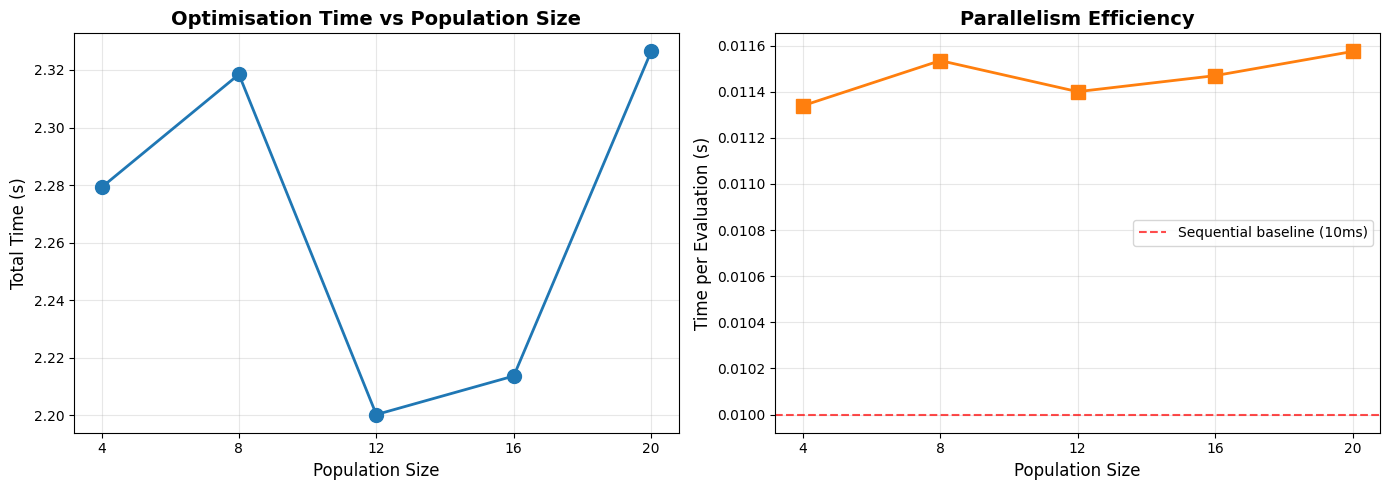


💡 Interpretation:
  - Time per eval < sequential baseline = good parallelism
  - Larger populations amortise overhead across more work
  - Diminishing returns when population > number of cores


In [7]:
# Visualize scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

pops = [r["population"] for r in results_pop]
times = [r["time"] for r in results_pop]
time_per_eval = [r["time_per_eval"] for r in results_pop]

# Total time vs population size
ax1.plot(pops, times, "o-", linewidth=2, markersize=10, color="#1f77b4")
ax1.set_xlabel("Population Size", fontsize=12)
ax1.set_ylabel("Total Time (s)", fontsize=12)
ax1.set_title("Optimisation Time vs Population Size", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.set_xticks(pops)

# Time per evaluation (measures parallelism efficiency)
ax2.plot(pops, time_per_eval, "s-", linewidth=2, markersize=10, color="#ff7f0e")
ax2.axhline(
    y=0.01, color="red", linestyle="--", label="Sequential baseline (10ms)", alpha=0.7
)
ax2.set_xlabel("Population Size", fontsize=12)
ax2.set_ylabel("Time per Evaluation (s)", fontsize=12)
ax2.set_title("Parallelism Efficiency", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3)
ax2.set_xticks(pops)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("  - Time per eval < sequential baseline = good parallelism")
print("  - Larger populations amortise overhead across more work")
print("  - Diminishing returns when population > number of cores")

## Effect of Evaluation Cost

Parallelism overhead (thread creation, synchronisation) matters less when evaluations are expensive:

In [8]:
# Test different evaluation costs
delays_ms = [1, 5, 10, 20, 50]
results_cost = []

print("Testing different evaluation costs...\n")

for delay in delays_ms:
    # Create problem with specific delay
    problem_delayed = (
        chron.ScalarBuilder()
        .with_objective(lambda x, d=delay: expensive_rosenbrock(x, delay_ms=d))
        .with_parameter("x", 1.0)
        .with_parameter("y", 1.0)
        .build()
    )

    # Sequential Nelder-Mead
    start = time.time()
    result_seq = chron.NelderMead().with_max_iter(50).run(problem_delayed, [0.0, 0.0])
    time_seq = time.time() - start

    # Parallel CMA-ES
    start = time.time()
    result_par = (
        chron.CMAES()
        .with_max_iter(25)
        .with_step_size(0.5)
        .with_population_size(12)
        .run(problem_delayed, [0.0, 0.0])
    )
    time_par = time.time() - start

    speedup = time_seq / time_par

    results_cost.append(
        {
            "delay_ms": delay,
            "time_seq": time_seq,
            "time_par": time_par,
            "speedup": speedup,
        }
    )

    print(
        f"Delay={delay:3d}ms: Sequential={time_seq:6.2f}s, Parallel={time_par:6.2f}s, "
        f"Speedup={speedup:.2f}x"
    )

print("\nDone!")

Testing different evaluation costs...



Delay=  1ms: Sequential=  0.14s, Parallel=  0.44s, Speedup=0.33x


Delay=  5ms: Sequential=  0.60s, Parallel=  1.81s, Speedup=0.33x


Delay= 10ms: Sequential=  1.14s, Parallel=  3.42s, Speedup=0.33x


Delay= 20ms: Sequential=  2.37s, Parallel=  7.03s, Speedup=0.34x


Delay= 50ms: Sequential=  5.41s, Parallel= 16.19s, Speedup=0.33x

Done!


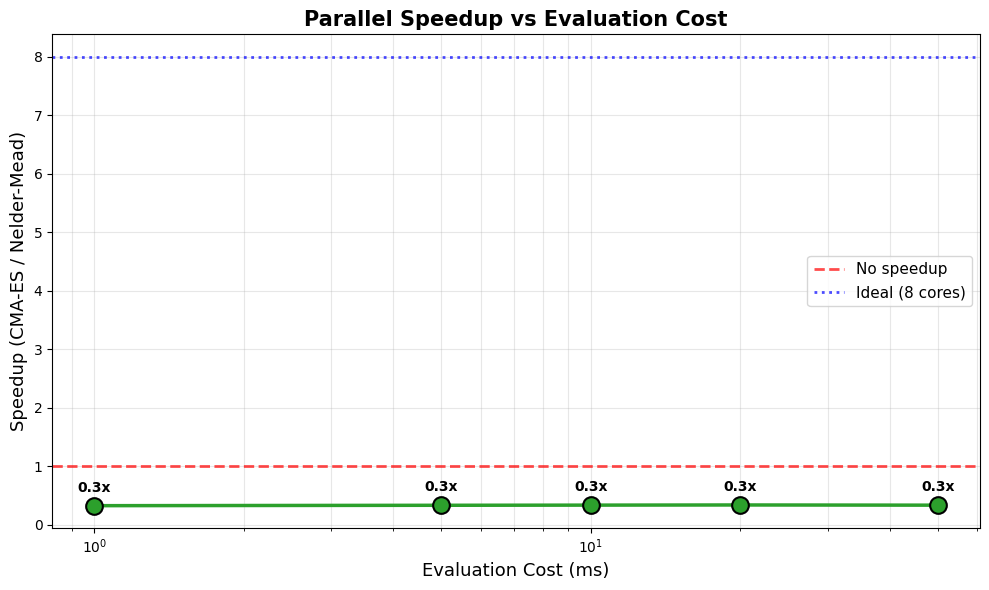


💡 Key Insight:
   Parallelism speedup increases with evaluation cost!
   Expensive evaluations → parallelisation overhead becomes negligible


In [9]:
# Visualize speedup vs evaluation cost
fig, ax = plt.subplots(figsize=(10, 6))

delays = [r["delay_ms"] for r in results_cost]
speedups = [r["speedup"] for r in results_cost]

ax.plot(
    delays,
    speedups,
    "o-",
    linewidth=2.5,
    markersize=12,
    color="#2ca02c",
    markeredgecolor="black",
    markeredgewidth=1.5,
)
ax.axhline(
    y=1.0, color="red", linestyle="--", label="No speedup", alpha=0.7, linewidth=2
)
ax.axhline(
    y=n_cores,
    color="blue",
    linestyle=":",
    label=f"Ideal ({n_cores} cores)",
    alpha=0.7,
    linewidth=2,
)

ax.set_xlabel("Evaluation Cost (ms)", fontsize=13)
ax.set_ylabel("Speedup (CMA-ES / Nelder-Mead)", fontsize=13)
ax.set_title("Parallel Speedup vs Evaluation Cost", fontsize=15, fontweight="bold")
ax.set_xscale("log")
ax.grid(True, alpha=0.3, which="both")
ax.legend(fontsize=11)

# Add value labels
for delay, speedup in zip(delays, speedups):
    ax.annotate(
        f"{speedup:.1f}x",
        xy=(delay, speedup),
        xytext=(0, 10),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print("   Parallelism speedup increases with evaluation cost!")
print("   Expensive evaluations → parallelisation overhead becomes negligible")

## Thread Safety Considerations

When using parallel optimisation, your **objective function must be thread-safe**:

### ✅ Thread-Safe Patterns
```python
# Pure functions (no shared state)
def objective(x):
    return np.sum(x**2)

# Immutable data structures
DATA = np.array([...])
def objective(x):
    return np.sum((x - DATA)**2)

# Read-only global state
MODEL_PARAMS = {...}
def objective(x):
    return simulate(x, MODEL_PARAMS)
```

### ❌ Not Thread-Safe
```python
# Shared mutable state
counter = 0
def objective(x):
    global counter
    counter += 1  # Race condition!
    return np.sum(x**2)

# Writing to files without locks
def objective(x):
    with open('log.txt', 'a') as f:  # Multiple threads writing!
        f.write(f'{x}\n')
    return np.sum(x**2)
```

### Solutions for Non-Thread-Safe Code

1. **Use locks** (but this reduces parallelism):
```python
from threading import Lock
lock = Lock()

def objective(x):
    with lock:
        # Critical section
        return result
```

2. **Disable parallelism** for problematic code (future feature)

3. **Refactor** to eliminate shared state

## Best Practices

### When to Use Parallel Optimisation

**✅ Parallelism is beneficial when:**
- Objective function is expensive (>10ms per evaluation)
- Problem has >3 parameters (larger populations useful)
- Multiple cores available
- Function is thread-safe
- Global search needed (CMA-ES vs Nelder-Mead)

**❌ Parallelism may not help when:**
- Function is very fast (<1ms)
- Low-dimensional problems (1-2 parameters)
- Limited cores available
- Thread-safety issues
- Sequential algorithms required (Nelder-Mead, Adam)

### Tuning for Parallel Performance

1. **Match population to cores**: `population_size ≈ 2 × n_cores` often works well
2. **Balance iterations**: Fewer iterations with larger population
3. **Profile first**: Measure single evaluation time
4. **Monitor efficiency**: Check if speedup scales with cores

## Performance Summary

Let's create a summary comparing all approaches:

In [10]:
# Summary comparison
summary_data = [
    ("Nelder-Mead (Sequential)", time_nm, result_nm.evaluations, 1.0),
    (
        "CMA-ES (Default Pop)",
        time_cmaes_default,
        result_cmaes_default.evaluations,
        time_nm / time_cmaes_default,
    ),
    (
        "CMA-ES (Large Pop)",
        time_cmaes_large,
        result_cmaes_large.evaluations,
        time_nm / time_cmaes_large,
    ),
]

print("\n" + "=" * 80)
print("PERFORMANCE SUMMARY")
print("=" * 80)
print(f"{'Method':<30} {'Time (s)':<12} {'Evals':<10} {'Speedup'}")
print("-" * 80)

for method, t, evals, speedup in summary_data:
    print(f"{method:<30} {t:<12.2f} {evals:<10} {speedup:.2f}x")

print("\n💡 Key Findings:")
print(f"   - Best speedup: {max(s for _, _, _, s in summary_data):.2f}x")
print(f"   - System cores: {n_cores}")
print(
    f"   - Parallel efficiency: {(max(s for _, _, _, s in summary_data) / n_cores * 100):.0f}%"
)


PERFORMANCE SUMMARY
Method                         Time (s)     Evals      Speedup
--------------------------------------------------------------------------------
Nelder-Mead (Sequential)       1.44         127        1.00x
CMA-ES (Default Pop)           3.40         301        0.42x
CMA-ES (Large Pop)             6.81         601        0.21x

💡 Key Findings:
   - Best speedup: 1.00x
   - System cores: 8
   - Parallel efficiency: 12%


## Key Takeaways

1. **CMA-ES automatically parallelises** population evaluations across CPU cores
2. **Speedup increases** with evaluation cost (overhead becomes negligible)
3. **Population size** controls parallel work per generation
4. **Thread safety** is critical - use pure functions or locks
5. **Best for expensive functions** (>10ms per evaluation)
6. **Monitor efficiency** - speedup should approach number of cores
7. **Trade-offs exist** - larger populations need more generations

## Next Steps

- [Tutorial 8: Advanced Cost Functions](08_advanced_cost_functions.ipynb) - Custom objective functions
- [Guide: Parallel Execution](../../guides/parallel-execution.md) - Detailed thread safety patterns
- [Guide: Tuning Optimisers](../../guides/tuning-optimizers.md) - Population size selection
- [API Reference: CMA-ES](../../api-reference/python/optimizers.md#cmaes) - Complete API

## Exercises

1. **Optimal Population**: Find the population size that minimises total time for your hardware

2. **Amdahl's Law**: Estimate the theoretical speedup limit based on your results

3. **Real Problem**: Apply parallel CMA-ES to an ODE fitting problem from Tutorial 2

4. **Scaling Study**: Measure how speedup changes with:
   - Number of parameters (2, 5, 10, 20)
   - Evaluation cost (1ms, 10ms, 100ms, 1s)
   - System load (run with background tasks)

5. **Thread Safety Bug**: Create a non-thread-safe objective function and observe the failure mode